In [1]:
list.files(path = "../input")
pacman::p_load(dplyr,
               here,
               purrr,
               readxl,
               magrittr,
               ggplot2,
               gridExtra,
               forecast,
               rlang,
               quantmod,
               tsibble,
               lubridate,
               zoo,
               stats,#for acf/pcf
               gridExtra,
               lmSubsets,
               xtable,
               readr,
               timeSeries,
               TSstudio,
               tseries,
               hrbrthemes,
               tidyr,
               leaps,
               tidyverse,
              randomForest,
              rpart,
              caret,
              keras,
              tensorflow,
              hrbrthemes,
              DALEX)
options(repr.plot.width = 14, repr.plot.height = 6)

[1] "casestudydataset"

In [2]:
DataMonthly <- read_xlsx(path = "/kaggle/input/casestudydataset/PredictorData2022.xlsx", sheet = "Monthly")
DataQuarterly <- read_xlsx(path = "/kaggle/input/casestudydataset/PredictorData2022.xlsx", sheet = "Quarterly")
DataAnnual <- read_xlsx(path = "/kaggle/input/casestudydataset/PredictorData2022.xlsx", sheet = "Annual")

new_colnames_dict <- c(
  "Time" = "yyyymm",
  "Time" = "yyyyq",
  "Time" = "yyyy",
  "SP500_Index" = "Index",
  "Dividends_12MonthSum" = "D12",
  "Earnings_12MonthSum" = "E12",
  "BookToMarket_Ratio" = "b/m",
  "TreasuryBill_Rate" = "tbl",
  "AAA_CorporateBond_Yield" = "AAA",
  "BAA_CorporateBond_Yield" = "BAA",
  "LongTermGovBond_Yield" = "lty",
  "NetEquityExpansion" = "ntis",
  "RiskFree_Rate" = "Rfree",
  "Inflation_CPI" = "infl",
  "LongTermRateOfReturn" = "ltr",
  "CorporateBond_Return" = "corpr",
  "StockVariance" = "svar",
  "CrossSectionalPremium" = "csp",
  "ConsumptionWealthIncomeRatio" = "cay", #check these variables
  "InvestmentCapitalRatio" = "ik",
  "Dividend3YearPriceRatio" = "D3",
  "Earnings3YearPriceRatio" = "E3",
  "ConsumptionWealthIncomeRatioMonthly" = "caym",
  "PercentageEquityIssuing" = "eqis"
)


filtered_dict_monthly <- new_colnames_dict[new_colnames_dict %in% colnames(DataMonthly)]
DataMonthly <- rename(DataMonthly, !!!filtered_dict_monthly)

filtered_dict_monthly <- new_colnames_dict[new_colnames_dict %in% colnames(DataQuarterly)]
DataQuarterly <- rename(DataQuarterly, !!!filtered_dict_monthly)

filtered_dict_monthly <- new_colnames_dict[new_colnames_dict %in% colnames(DataAnnual)]
DataAnnual <- rename(DataAnnual, !!!filtered_dict_monthly)


convert_to_numeric <- function(data) {
  for (i in names(data)) {
    if (class(data[[i]]) == "character") {
      data[[i]] <- as.numeric(data[[i]])
    }
  }
  return(data)
}

DataMonthly %<>% convert_to_numeric()
DataQuarterly %<>% convert_to_numeric()
DataAnnual %<>% convert_to_numeric()


DataMonthly$Time <- zoo::as.yearmon(as.character(DataMonthly$Time), format="%Y%m")
DataMonthly %<>% select(-CRSP_SPvw, -CRSP_SPvwx)


DataQuarterly$Time <- zoo::as.yearqtr(as.character(DataQuarterly$Time), format="%Y%q")
DataQuarterly %<>% select(-CRSP_SPvw, -CRSP_SPvwx)


DataAnnual$Time <- zoo::as.yearmon(paste0(as.character(DataAnnual$Time), "-01"), format="%Y-%m")
DataAnnual %<>% select(-CRSP_SPvw, -CRSP_SPvwx)


#Calculate Returns
calculate_returns <- function(input){
  input %<>% mutate(returns = as.vector(quantmod::Delt(SP500_Index))) 
  input %<>% mutate(ExcessReturn = returns - RiskFree_Rate)
  input %<>% select(-returns, -RiskFree_Rate, -SP500_Index)
  return(input)
}

lag_predictors <- function(input){
  output <- input %>%
    mutate(across(-c(Time, ExcessReturn), lag, .names = "lag_{.col}")) %>% 
    select(Time, ExcessReturn, starts_with("lag_")) %>% 
    slice(-1) 
  return(output)
}


DataMonthly %<>% calculate_returns()
DataQuarterly %<>% calculate_returns()
DataAnnual %<>% calculate_returns()


#Filtering Data to Handle NULL values and Dropping lag_CrossSectionalPremium
DataMonthly <- subset(DataMonthly, select = -c(CrossSectionalPremium))
DataQuarterly <- subset(DataQuarterly, select = -c(CrossSectionalPremium))
DataAnnual <- subset(DataAnnual, select = -c(CrossSectionalPremium))



DataMonthly %<>% lag_predictors()
DataQuarterly %<>% lag_predictors()
DataAnnual %<>% lag_predictors()



n_lags <- 10


# Generate lagged columns using base R
for (i in 1:n_lags) {
  DataMonthly[[paste0("lag_", i)]] <- c(rep(NA, i), head(DataMonthly$ExcessReturn, -i))
  DataQuarterly[[paste0("lag_", i)]] <- c(rep(NA, i), head(DataQuarterly$ExcessReturn, -i))
  DataAnnual[[paste0("lag_", i)]] <- c(rep(NA, i), head(DataAnnual$ExcessReturn, -i))    
}



# Remove rows with NA resulting from lag creation
DataMonthly <- DataMonthly[complete.cases(DataMonthly$lag_10), ]

DataQuarterly <- DataQuarterly[complete.cases(DataQuarterly$lag_10), ]

DataAnnual <- DataAnnual[complete.cases(DataAnnual$lag_10), ]


#Filtering Data After 1927
DataMonthly <- DataMonthly[DataMonthly$Time >= zoo::as.yearmon("1927-01", format = "%Y-%m"), ]
threshold_yearqtr <- as.yearqtr("1927 Q1", format = "%Y Q%q")
threshold_date <- as.Date(as.yearmon(threshold_yearqtr))
DataQuarterly <- DataQuarterly[as.Date(DataQuarterly$Time) >= threshold_date, ]
DataAnnual <- DataAnnual[DataAnnual$Time >= zoo::as.yearmon("1927-01", format = "%Y-%m"), ]


n_lags <- 10
selected_columns <- c("Time","ExcessReturn",paste0("lag_", 1:n_lags))
Monthly_lagged_data <- DataMonthly[selected_columns]
Quarterly_lagged_data <- DataQuarterly[selected_columns]
Annual_lagged_data <- DataAnnual[selected_columns]

# Use 'Time' as an index
#rownames(Monthly_lagged_data) <- Monthly_lagged_data$Time
#rownames(DataMonthly) <- DataMonthly$Time


# Removes Time columns 
#Monthly_lagged_data <- Monthly_lagged_data %>% select(-Time)
#DataMonthly <- DataMonthly %>% select(-Time)  
tail(DataMonthly)

Time,ExcessReturn,lag_Dividends_12MonthSum,lag_Earnings_12MonthSum,lag_BookToMarket_Ratio,lag_TreasuryBill_Rate,lag_AAA_CorporateBond_Yield,lag_BAA_CorporateBond_Yield,lag_LongTermGovBond_Yield,lag_NetEquityExpansion,⋯,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
<yearmon>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Jul 2022,0.09031635,64.45251,190.5333,0.2181874,0.0223,0.0406,0.0521,0.0290,-0.006120552,⋯,-0.08451999,-0.0002467561,-0.0880567191,0.0356732388,-0.0313605209,-0.0525850891,0.0436128750,-0.008433731,0.069143873,-0.047569140
Aug 2022,-0.04434012,64.88541,188.8067,0.2274292,0.0263,0.0407,0.0515,0.0290,-0.009731794,⋯,0.09031635,-0.0845199932,-0.0002467561,-0.0880567191,0.0356732388,-0.0313605209,-0.0525850891,0.043612875,-0.008433731,0.069143873
Sep 2022,-0.09529570,65.31831,187.0800,0.2494784,0.0313,0.0459,0.0569,0.0352,-0.011291950,⋯,-0.04434012,0.0903163476,-0.0845199932,-0.0002467561,-0.0880567191,0.0356732388,-0.0313605209,-0.052585089,0.043612875,-0.008433731
Oct 2022,0.07756345,65.85315,182.3033,0.2189351,0.0372,0.0510,0.0626,0.0398,-0.015252475,⋯,-0.09529570,-0.0443401192,0.0903163476,-0.0845199932,-0.0002467561,-0.0880567191,0.0356732388,-0.031360521,-0.052585089,0.043612875
Nov 2022,0.05085286,66.38799,177.5267,0.2071824,0.0415,0.0490,0.0607,0.0389,-0.017011396,⋯,0.07756345,-0.0952957016,-0.0443401192,0.0903163476,-0.0845199932,-0.0002467561,-0.0880567191,0.035673239,-0.031360521,-0.052585089
Dec 2022,-0.06227145,66.92283,172.7500,0.2161987,0.0425,0.0443,0.0559,0.0362,-0.021245776,⋯,0.05085286,0.0775634546,-0.0952957016,-0.0443401192,0.0903163476,-0.0845199932,-0.0002467561,-0.088056719,0.035673239,-0.031360521


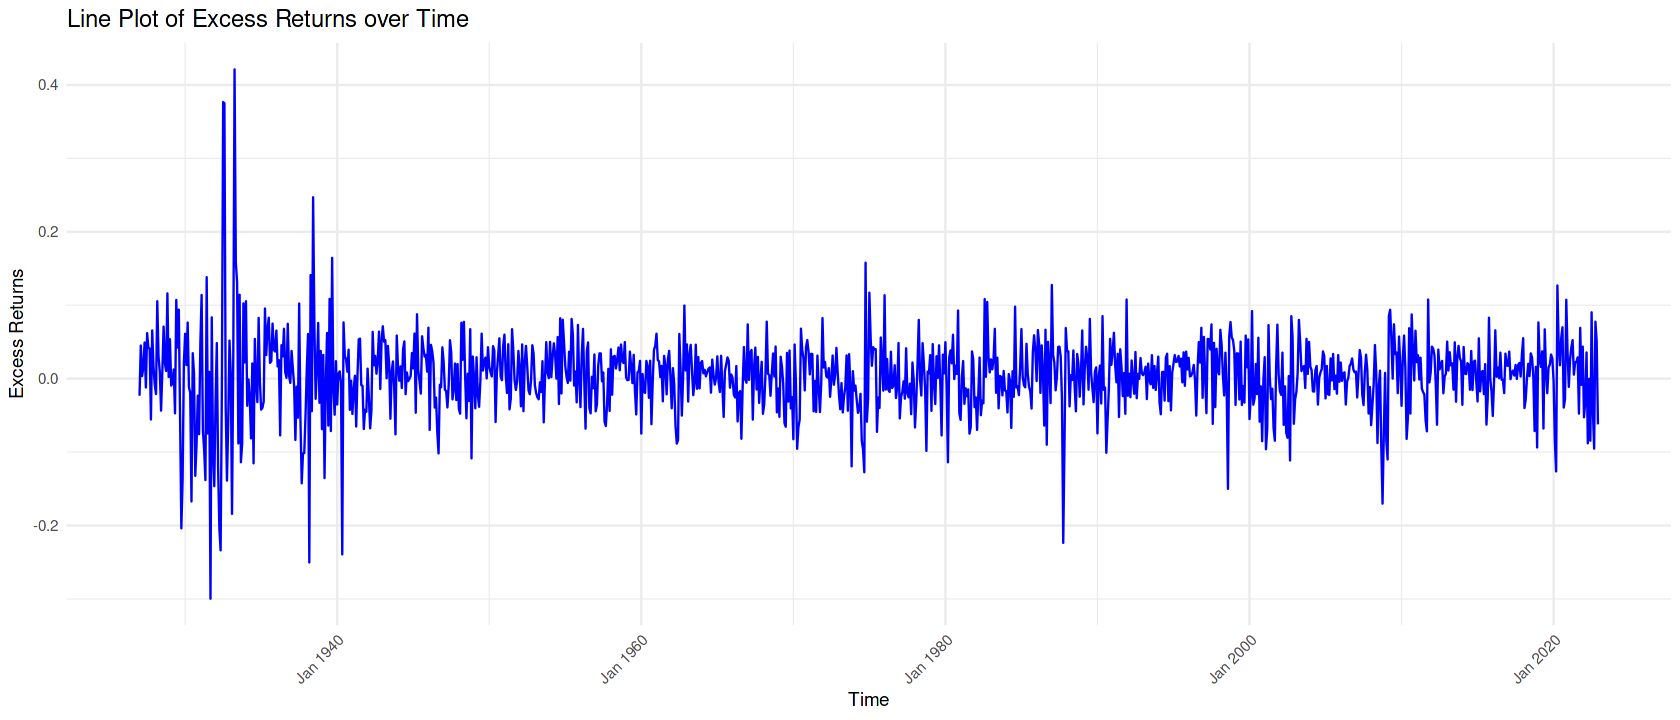

In [3]:
plot <- function (filtered_data){
ggplot(filtered_data, aes(x = Time, y = ExcessReturn)) +
  geom_line(color = "blue") +
  labs(x = "Time", y = "Excess Returns") +
  ggtitle("Line Plot of Excess Returns over Time") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14),
    axis.text.x = element_text(angle = 45, hjust = 1),
    
  )
    
}

plot(Monthly_lagged_data)

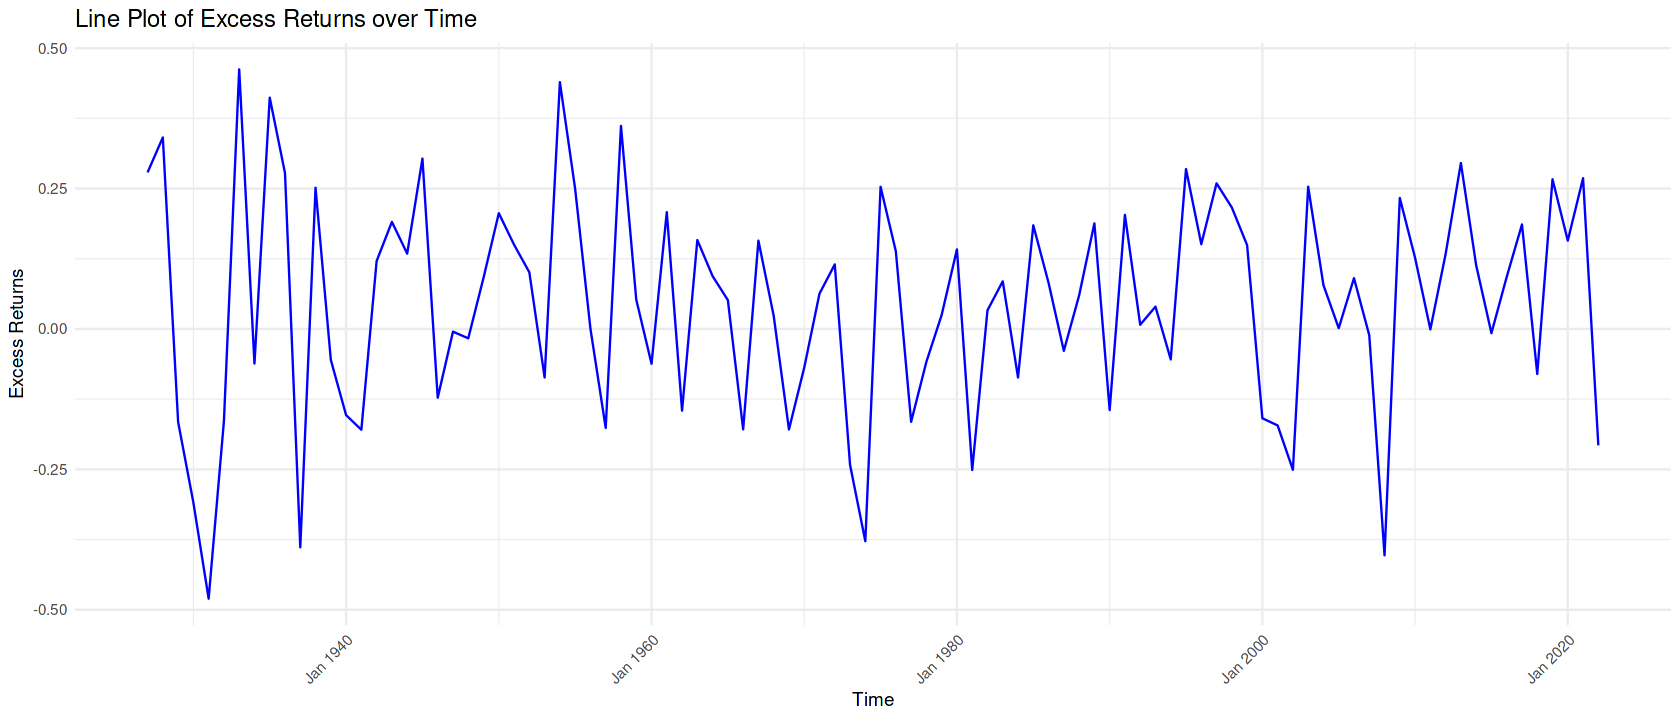

In [4]:
plot(DataAnnual)

## AR

In [5]:
AR_rolling_forecast <- function(myTimeSeries, window_size, order) {
  all_predictions <- numeric(0)
  
  for (i in seq(nrow(myTimeSeries) - window_size + 1, nrow(myTimeSeries), 1)) {
    start_window <- i - window_size + 1
    end_window <- i - 1
    window_data <- myTimeSeries[start_window:end_window, ]
    
    # Fit AR model
    ar_model <- Arima(window_data$ExcessReturn, order = order)
    
    next_window <- myTimeSeries[end_window + 1, ]
    
    # Make predictions for the next observation
    next_window_prediction <- forecast(ar_model, h = 1)$mean
    all_predictions <- c(all_predictions, next_window_prediction)
  }
  
  actual_values <- tail(myTimeSeries, window_size)
  residuals <- actual_values$ExcessReturn - all_predictions
  rmse <- sqrt(mean(residuals^2))
  
  time_index <- seq_along(actual_values)
  plot_data <- data.frame(Time = actual_values$Time, ExcessReturn = actual_values$ExcessReturn, Predicted = all_predictions, Residuals = residuals)  
  
  plot <- ggplot(plot_data, aes(x = Time)) +
    geom_line(aes(y = ExcessReturn), color = "grey", size = 1) +
    geom_line(aes(y = Predicted), color = "blue", linetype = "dashed", size = 1) +
    labs(x = "Time", y = "Excess Returns") +
    ggtitle("Actual vs Predicted Excess Returns over Time") +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 14),
      axis.text.x = element_text(angle = 45, hjust = 1)
    ) +
    scale_color_manual(values = c("blue", "red"))
  
  return(list(plot = plot, rmse = rmse, residuals = residuals))
}


## RT

[1] 0.03985787

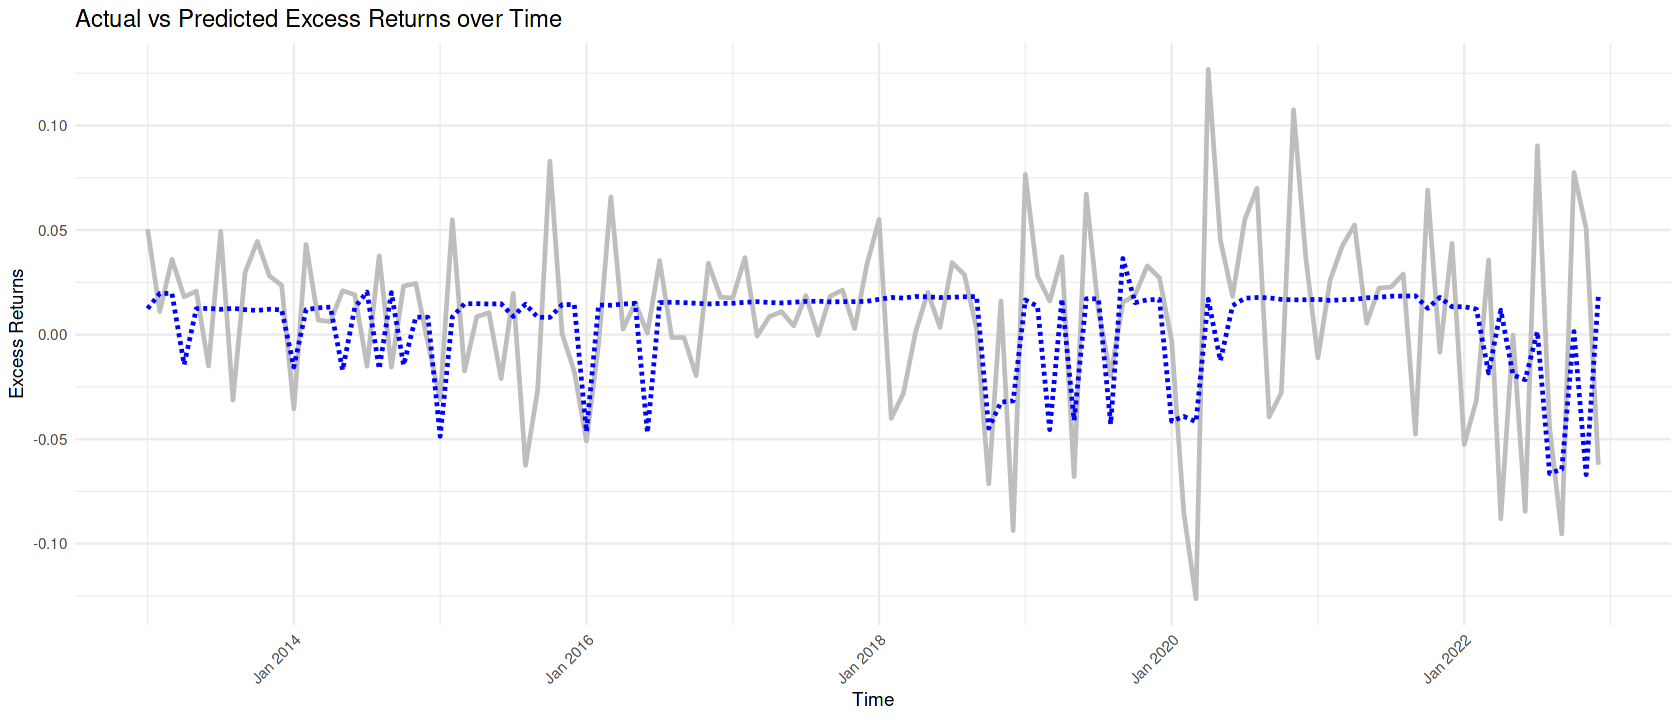

In [10]:
RT_rolling_forecast <- function(myTimeSeries, window_size,complexity) {
  all_predictions <- numeric(0)
  
  # Start the loop from the 10th year from the end
  for (i in seq(nrow(myTimeSeries) - window_size + 1, nrow(myTimeSeries), 1)) {
    start_window <- i - window_size + 1
    end_window <- i - 1
    window_data <- myTimeSeries[start_window:end_window, ]
    
    # Fit an rpart (single decision tree) model
    rt_model <- rpart(ExcessReturn ~ ., data = window_data, control = rpart.control(cp = complexity))
    
    next_window <- myTimeSeries[end_window + 1, ]
    next_window_predictors <- next_window[, -which(names(next_window) == "ExcessReturn")]
    
    # Ensure the length of 'next_window_predictors' matches the number of predictors
    next_window_prediction <- predict(rt_model, next_window_predictors)
    all_predictions <- c(all_predictions, next_window_prediction)
  }
  
  # Assuming you have the actual ExcessReturn values for comparison
  actual_values <- tail(myTimeSeries, window_size)
  residuals <- actual_values$ExcessReturn - all_predictions
  rmse <- sqrt(mean(residuals^2))
  plot_data <- data.frame(Time = actual_values$Time, ExcessReturn = actual_values$ExcessReturn, Predicted = all_predictions)  
  
  # Plot
  plot <- ggplot(plot_data, aes(x = Time)) +
    geom_line(aes(y = ExcessReturn), color = "grey", size = 1) +
    geom_line(aes(y = Predicted), color = "blue", linetype = "dashed", size = 1) +
    labs(x = "Time", y = "Excess Returns") +
    ggtitle("Actual vs Predicted Excess Returns over Time") +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 14),
      axis.text.x = element_text(angle = 45, hjust = 1)
    ) +
    scale_color_manual(values = c("blue", "red"))
  
  return(list(plot = plot, rmse = rmse, residuals = residuals))
}

## RF

In [12]:
RF_rolling_forecast <- function(myTimeSeries, window_size, tree) {
  all_predictions <- numeric(0)
  
  # Start the loop from the 10th year from the end
  for (i in seq(nrow(myTimeSeries) - window_size + 1, nrow(myTimeSeries), 1)) {
    start_window <- i - window_size + 1
    end_window <- i - 1
    window_data <- myTimeSeries[start_window:end_window, ]
    
    rf_model <- randomForest(ExcessReturn ~ ., data = window_data, ntree= tree)
    
    next_window <- myTimeSeries[end_window + 1, ]
    next_window_predictors <- next_window[, -which(names(next_window) == "ExcessReturn")]
    
    # Ensure the length of 'next_window_predictors' matches the number of predictors
    next_window_prediction <- predict(rf_model, next_window_predictors)
    all_predictions <- c(all_predictions, next_window_prediction)
  }
  
# Assuming you have the actual ExcessReturn values for comparison
actual_values <- tail(myTimeSeries, window_size)
residuals <- actual_values$ExcessReturn - all_predictions
rmse <- sqrt(mean(residuals^2))
  time_index <- seq_along(actual_values)
  plot_data <- data.frame(Time = actual_values$Time, ExcessReturn = actual_values$ExcessReturn, Predicted = all_predictions)  
  
  # Plot
  plot <- ggplot(plot_data, aes(x = Time)) +
    geom_line(aes(y = ExcessReturn), color = "grey", size = 1) +
    geom_line(aes(y = Predicted), color = "blue", linetype = "dashed", size = 1) +
    labs(x = "Time", y = "Excess Returns") +
    ggtitle("Actual vs Predicted Excess Returns over Time") +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 14),
      axis.text.x = element_text(angle = 45, hjust = 1)
    ) +
    scale_color_manual(values = c("blue", "red"))
    
  return(list(plot = plot, rmse = rmse, residuals = residuals))
    
}

[1] 0.04332301

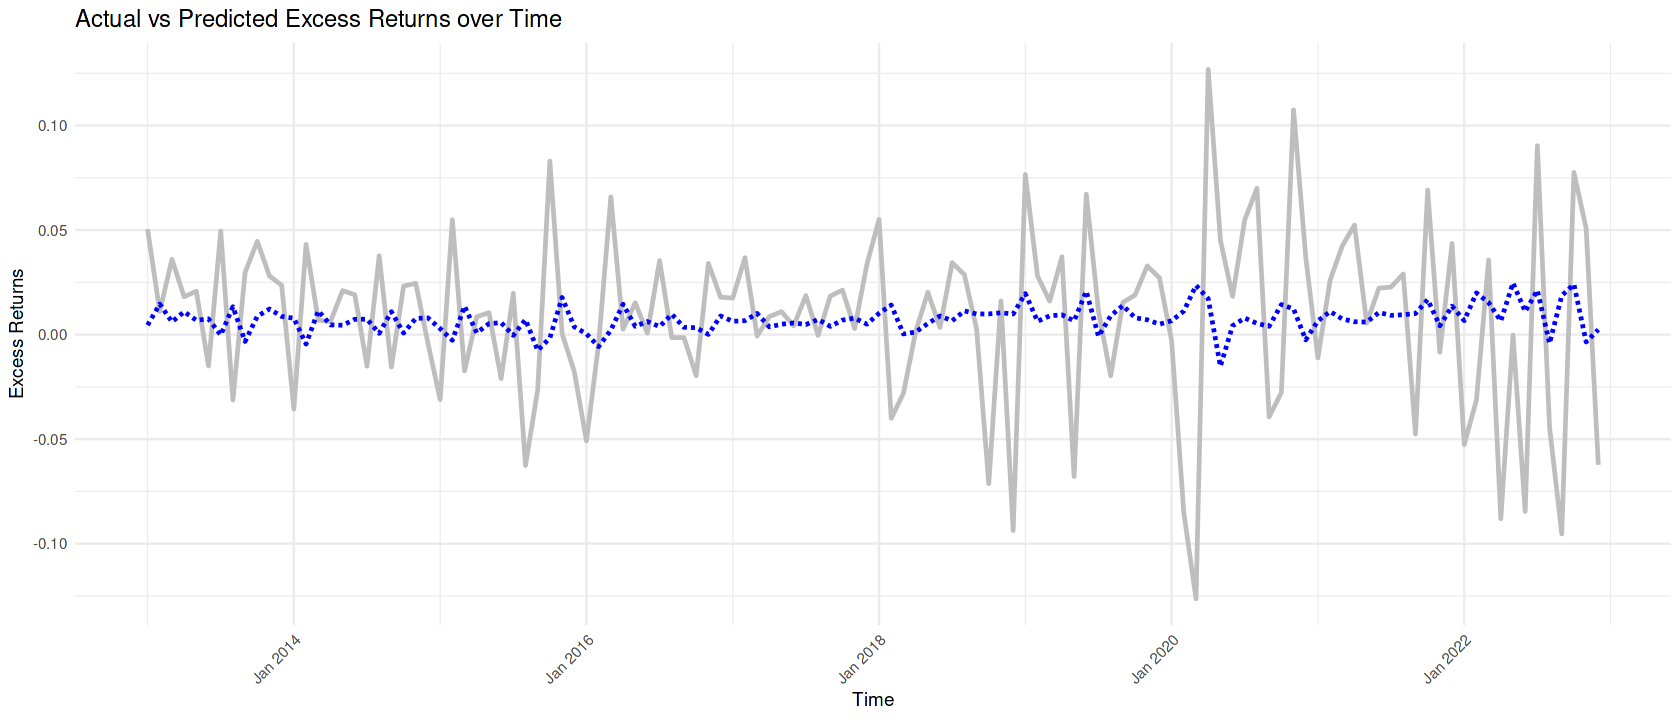

In [14]:
arm <- AR_rolling_forecast(DataMonthly, 120,c(1,0,0))
arm$rmse
arm$plot

[1] 0.03974583

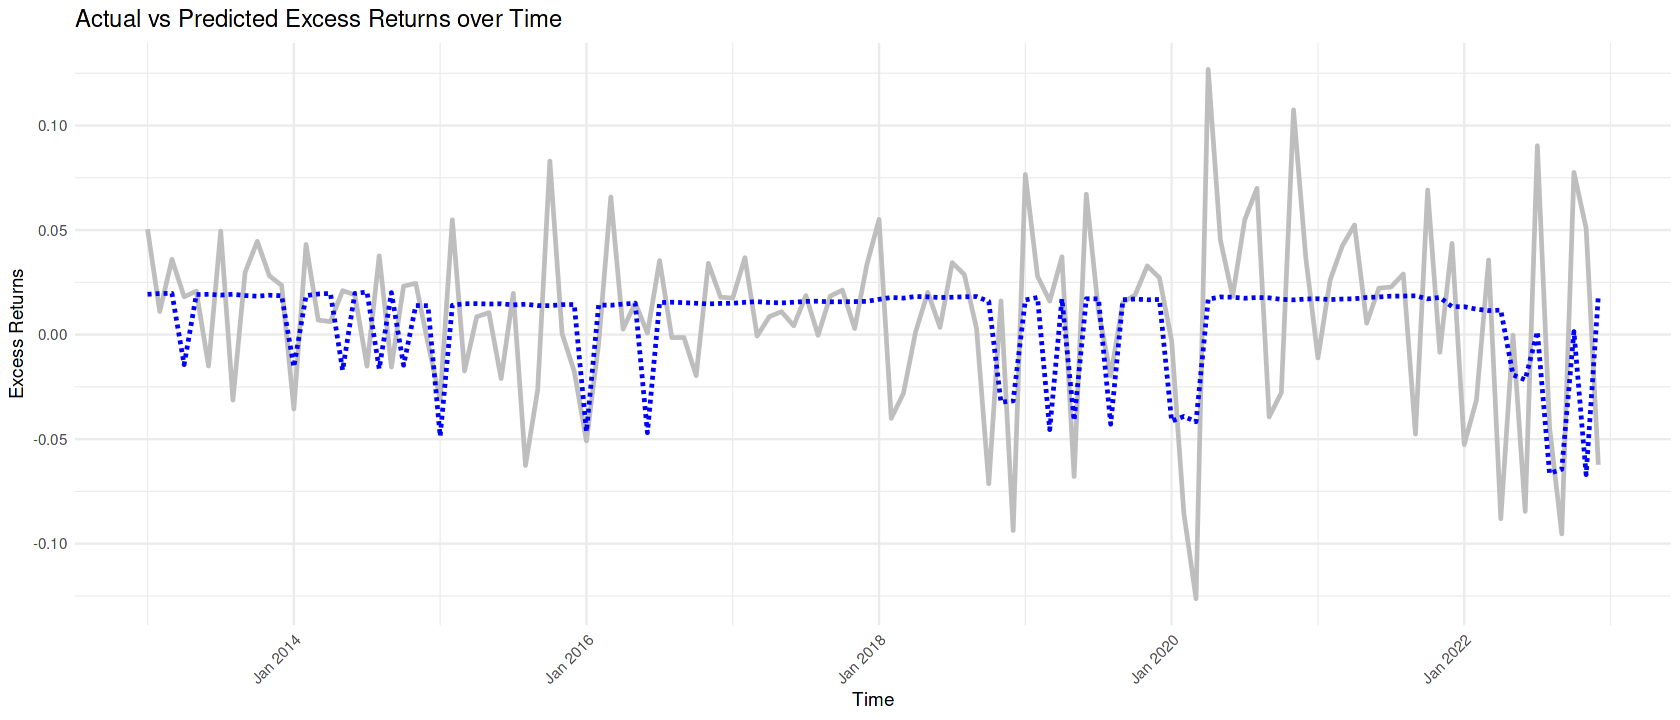

In [13]:
rtm <- RT_rolling_forecast(DataMonthly,120, 0.1)
rtm$rmse
rtm$plot

In [15]:
# Diebold-Mariano Test
dm.test(
  arm$residuals,
  rtm$residuals,
  alternative = "two.sided",
  h = 50,
  power = 2,
  varestimator = "acf"
)



	Diebold-Mariano Test

data:  arm$residualsrtm$residuals
DM = 2.9798, Forecast horizon = 50, Loss function power = 2, p-value =
0.003497
alternative hypothesis: two.sided
